# PBL05_機械の予知保全　サンプルコード

当サンプルコードは、「PBL05_機械の予知保全のテーマのAI課題（演習④）」において、配布されたファイルを分析し、投稿ファイルを作成するまでの大まかな流れを、ソースコードや実行結果とともに示したものとなっています。ガイドコンテンツとともに、詳細な分析を行う足がかりとしてご利用ください。

当サンプルコードは、以下のような流れで構成されています。

1. データの読み込み
2. データの整理・概要把握
3. 特徴量生成
4. モデリング
5. 提出用ファイルの作成

なお、ソースコードは配布ファイルがすべて同じディレクトリ内に存在することを想定しています。

# ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

/Users/n.kinugasa/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/n.kinugasa/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# 1. データの読み込み: librosa.load()

読み込むファイルリストを作成
- files_normal：全ての機械の正常音データ
- files_anomaly：全ての機械の異常音データ
- files_test：予測データ

In [6]:
files_normal = sorted(glob.glob(os.path.abspath('train/*/normal/*.wav')))
files_anomaly = sorted(glob.glob(os.path.abspath('train/*/anomaly/*.wav')))
files_test = sorted(glob.glob(os.path.abspath('test/*.wav')))

ファイルリストから各ファイルを読み込み

In [7]:
normal = []
for file in files_normal:
    y,sr = librosa.load(file,sr=None)
    normal.append(y)
normal = np.array(normal)

anomaly = []
for file in files_anomaly:
    y,sr = librosa.load(file,sr=None)
    anomaly.append(y)
anomaly = np.array(anomaly)

test = []
for file in files_test:
    y,sr = librosa.load(file,sr=None)
    test.append(y)
test = np.array(test)

# 2. データの整理、概要把握

音の確認

正常音

In [32]:
import IPython.display
IPython.display.Audio("train/machine01/normal/000.wav")

異常音

In [33]:
IPython.display.Audio("train/machine01/anomaly/000.wav")

### 波形の描画

正常音

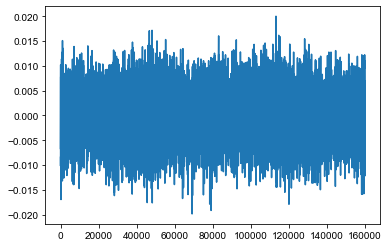

In [30]:
plt.plot(normal[0])

異常音

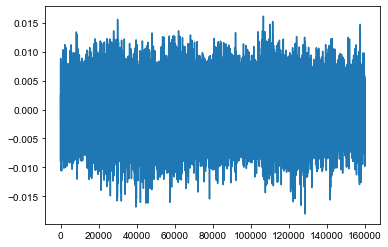

In [25]:
plt.plot(anomaly[0])

一部を拡大表示

正常音

(0.0, 1000.0)

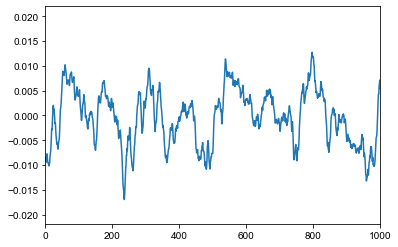

In [31]:
plt.plot(normal[0])
plt.xlim([0,1000])

異常音

(0.0, 1000.0)

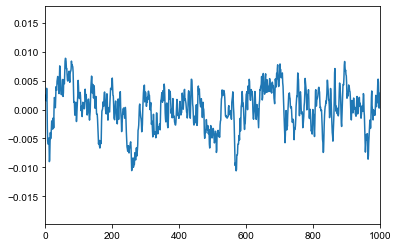

In [28]:
plt.plot(anomaly[0])
plt.xlim([0,1000])

# 3. 特徴量生成
- <font color="#FF0000"><strong>【ポイント】予測モデルの精度向上の為には適切な特徴量を追加することが一つのポイントとなりますので、どんな特徴量を作るべきかを検討しましょう</strong></font>
- こちらではメルスペクトログラムを作成して特徴量に使用します。

### メルスペクトログラムの作成

In [8]:
melspec_normal = []
for n in normal:
    m = librosa.feature.melspectrogram(n,n_mels=256)
    m = librosa.power_to_db(m).astype(np.float32)
    melspec_normal.append(m)
melspec_normal = np.array(melspec_normal)
melspec_normal[0]

melspec_anomaly = []
for a in anomaly:
    m = librosa.feature.melspectrogram(a,n_mels=256)
    m = librosa.power_to_db(m).astype(np.float32)
    melspec_anomaly.append(m)
melspec_anomaly = np.array(melspec_anomaly)

melspec_test = []
for t in test:
    m = librosa.feature.melspectrogram(t,n_mels=256)
    m = librosa.power_to_db(m).astype(np.float32)
    melspec_test.append(m)
melspec_test = np.array(melspec_test)

### メルスペクトログラムの可視化

<AxesSubplot:>

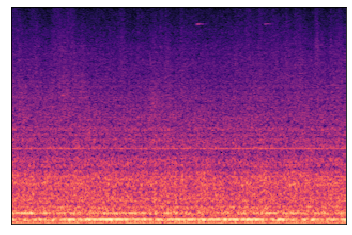

In [43]:
import librosa.display
librosa.display.specshow(melspec_normal[0])

# 4. モデリング
- <font color="#FF0000"><strong>【ポイント】利用するモデルによっても予測精度は変わります。様々なモデル×パラメータチューニングを試してみましょう。</strong></font>
- ここでは、ランダムフォレストを使用します。

### 学習データの作成

In [9]:
# 正常音と異常音を結合
train_X = np.concatenate([melspec_normal, melspec_anomaly])

# メルスペクトログラムは2次元なので1次元に変換
train_X = train_X.reshape(train_X.shape[0],-1)
test_X = melspec_test.reshape(melspec_test.shape[0],-1)

# 正解ラベルを作成
train_y = np.concatenate([np.zeros(len(melspec_normal)), np.ones(len(melspec_anomaly))])


### モデルの学習・予測

In [10]:
from sklearn.ensemble import RandomForestClassifier

# モデルインスタンスの生成
model = RandomForestClassifier()

# モデルの学習
model.fit(train_X, train_y)

RandomForestClassifier()

In [11]:
# 学習済みのモデルを使用してテストデータに関する予測値を算出する
pred = model.predict(test_X)
pred

array([0., 1., 1., ..., 0., 1., 1.])

# 5. 提出用ファイルの作成: pandas.DataFrame.to_csv()

sample_submission.csvを元に、提出用ファイルを作成する

In [12]:
# sample_submissionの中身を確認
sub = pd.read_csv('sample_submission.csv', header=None)

sub.head()

,0,1
0,machine01_000.wav,0
1,machine01_001.wav,0
2,machine01_002.wav,0
3,machine01_003.wav,0
4,machine01_004.wav,0


In [18]:
# sample_submissionの右側のカラムに予測値を代入する。
sub[1] = pred.astype('int')

sub.head()

,0,1
0,machine01_000.wav,0
1,machine01_001.wav,1
2,machine01_002.wav,1
3,machine01_003.wav,0
4,machine01_004.wav,0


In [19]:
# 予測ファイルの生成
sub.to_csv('my_submission.csv', index=False, header=False)